In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [66]:
SEQ_LEN = 128
W, H = 50, 50

data_input = lambda: pong.games_generator(W, H, SEQ_LEN)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32, tf.bool)),
).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [67]:
X, Y = list(make_dataset(64).take(1))[0]
(directions, controls), (frames, game_over) = X, Y

directions.shape, controls.shape, frames.shape, game_over.shape

(TensorShape([Dimension(64)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(2)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(50), Dimension(50)]),
 TensorShape([Dimension(64), Dimension(128)]))

In [84]:
class Model:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None
        direction_inp = tf.keras.layers.Input(shape=(1), name='dir_input', batch_size=bs)
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input', batch_size=bs)

        self.hidden_direction = tf.keras.layers.Dense(
            200,
            name='hidden_direction',
            activation='relu'
        )

        self.activation_direction = tf.keras.layers.Dense(
            200,
            name='activation_direction',
            activation='relu'
        )

        self.transformed_user_input = tf.keras.layers.LSTM(
            200,
            return_sequences=True,
            name='transformed_user_input',
            activation='relu'
        )

        self.x1 = tf.keras.layers.LSTM(
            200,
            return_sequences=True,
            name='x',
            stateful=stateful,
            activation='relu'
        )

        self.x2 = tf.keras.layers.GRU(
            200, return_sequences=True, name='x2',
            stateful=stateful,
            activation='relu'
        )
        self.x3 = tf.keras.layers.GRU(
            200, return_sequences=True, name='x3',
            stateful=stateful,
            activation='relu'
        )

        self.frames1 = tf.keras.layers.Dense(W * H, activation='sigmoid')
        self.frames2 = tf.keras.layers.Reshape((-1, W, H), name='frames')

        self.game_over1 = tf.keras.layers.Dense(1)
        self.game_over2 = tf.keras.layers.Lambda(
            lambda i: tf.squeeze(i, [-1], name='game_over')
        )
        
        hd = self.hidden_direction(direction_inp)
        ad = self.activation_direction(direction_inp)
        ui = self.transformed_user_input(user_input)
        x1 = self.x1(ui, initial_state=[ad, hd])
        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)

        self.net = tf.keras.Model([direction_inp, user_input], [f2, g2])

        self.net.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['mse', 'accuracy']
        )
        
    def copy_in_stateful_model(self):
        stateful = Model(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
            
        return stateful

    def init(self, direction):
        direction = np.array(direction).reshape((1, 1))
        self.init_dir = tf.convert_to_tensor(direction, dtype=tf.float32)
        self.first_time = True
        
    def single_step_predict(self, user_input):
        user_input = np.array(user_input).reshape((1, 1, 2))
        user_input = tf.convert_to_tensor(user_input, dtype=tf.float32)
        ui = self.transformed_user_input(user_input)

        if self.first_time:
            self.first_time = False

            hd = self.hidden_direction(self.init_dir)
            ad = self.activation_direction(self.init_dir)
            x1 = self.x1(ui, initial_state=[ad, hd])
        else:
            x1 = self.x1(ui)

        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)
        
        return f2.numpy().reshape(50, 50), g2.numpy()

In [85]:
model = Model()
# model.net.summary()

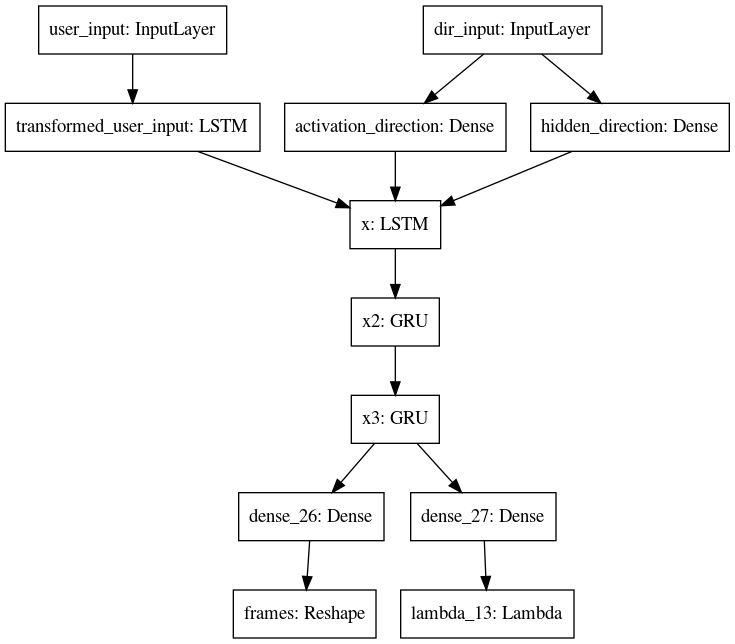

In [86]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [87]:
def plot_pairwise_frames(frame_nums):
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames, game_over) = X, Y
    pred_frames, _ = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [88]:
frame_nums = [1, 4, 8, 16, 32, 64, 127]

In [89]:
class PlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames(frame_nums)
        plt.show()
        
callbacks = [PlotCallback()]

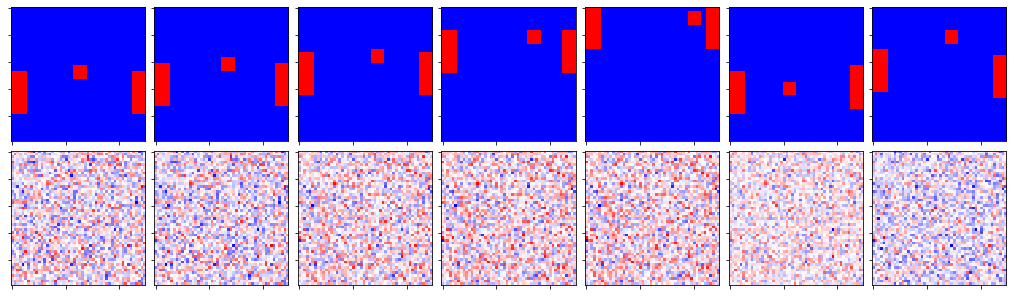

Epoch 1/150
100/100 [==============================] - 121s 1s/step - loss: 0.7214 - frames_loss: 0.5312 - lambda_13_loss: 0.1902 - frames_mean_squared_error: 0.1775 - frames_acc: 0.9124 - lambda_13_mean_squared_error: inf - lambda_13_acc: 0.9630 - val_loss: 0.3911 - val_frames_loss: 0.1974 - val_lambda_13_loss: 0.1937 - val_frames_mean_squared_error: 0.0548 - val_frames_acc: 0.9205 - val_lambda_13_mean_squared_error: 0.0565 - val_lambda_13_acc: 0.9537


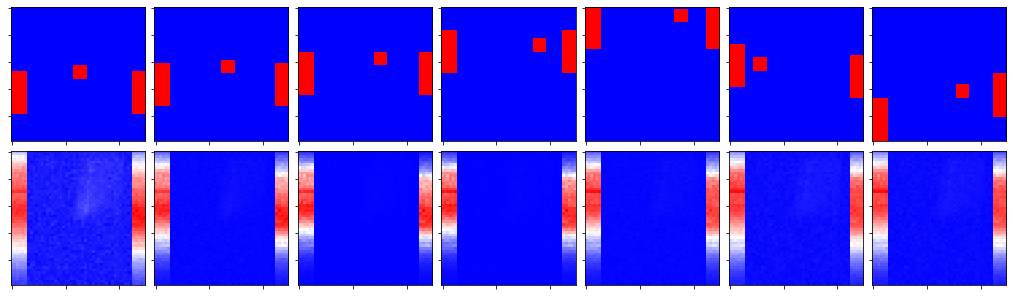

Epoch 2/150
100/100 [==============================] - 112s 1s/step - loss: 0.3637 - frames_loss: 0.2167 - lambda_13_loss: 0.1470 - frames_mean_squared_error: 0.0585 - frames_acc: 0.9253 - lambda_13_mean_squared_error: 0.1064 - lambda_13_acc: 0.9646 - val_loss: 0.2188 - val_frames_loss: 0.1773 - val_lambda_13_loss: 0.0416 - val_frames_mean_squared_error: 0.0509 - val_frames_acc: 0.9296 - val_lambda_13_mean_squared_error: 0.1085 - val_lambda_13_acc: 0.9832


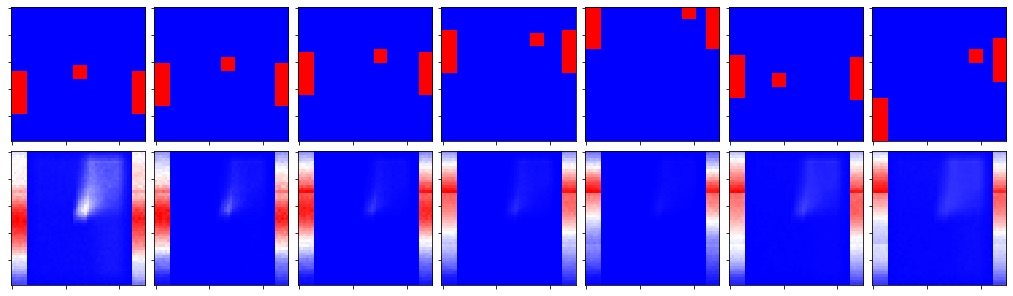

Epoch 3/150
100/100 [==============================] - 112s 1s/step - loss: 0.2884 - frames_loss: 0.1776 - lambda_13_loss: 0.1108 - frames_mean_squared_error: 0.0502 - frames_acc: 0.9315 - lambda_13_mean_squared_error: 0.1193 - lambda_13_acc: 0.9651 - val_loss: 0.2363 - val_frames_loss: 0.1691 - val_lambda_13_loss: 0.0672 - val_frames_mean_squared_error: 0.0487 - val_frames_acc: 0.9327 - val_lambda_13_mean_squared_error: 0.0778 - val_lambda_13_acc: 0.9672


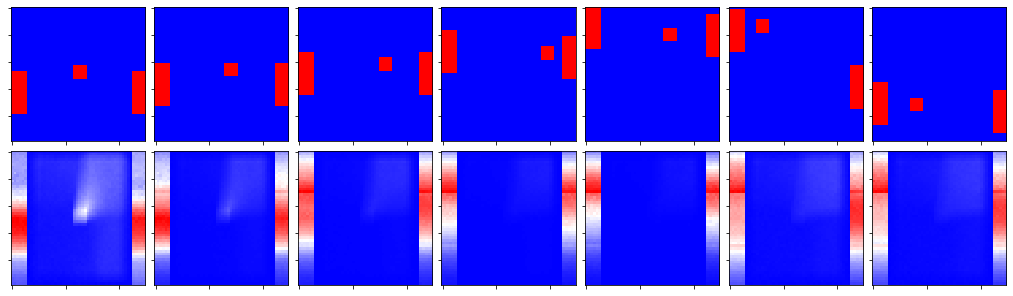

Epoch 4/150
100/100 [==============================] - 112s 1s/step - loss: 0.2201 - frames_loss: 0.1535 - lambda_13_loss: 0.0667 - frames_mean_squared_error: 0.0432 - frames_acc: 0.9406 - lambda_13_mean_squared_error: 0.4232 - lambda_13_acc: 0.9645 - val_loss: 0.1772 - val_frames_loss: 0.1402 - val_lambda_13_loss: 0.0370 - val_frames_mean_squared_error: 0.0393 - val_frames_acc: 0.9463 - val_lambda_13_mean_squared_error: 1.2029 - val_lambda_13_acc: 0.9843


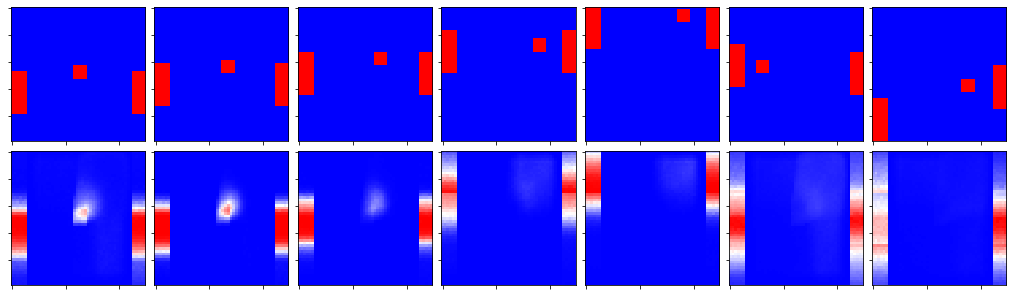

Epoch 5/150
100/100 [==============================] - 112s 1s/step - loss: 0.1852 - frames_loss: 0.1293 - lambda_13_loss: 0.0558 - frames_mean_squared_error: 0.0365 - frames_acc: 0.9502 - lambda_13_mean_squared_error: 41240362507757105971200.0000 - lambda_13_acc: 0.9741 - val_loss: 0.1513 - val_frames_loss: 0.1202 - val_lambda_13_loss: 0.0311 - val_frames_mean_squared_error: 0.0345 - val_frames_acc: 0.9521 - val_lambda_13_mean_squared_error: 2.4208 - val_lambda_13_acc: 0.9884


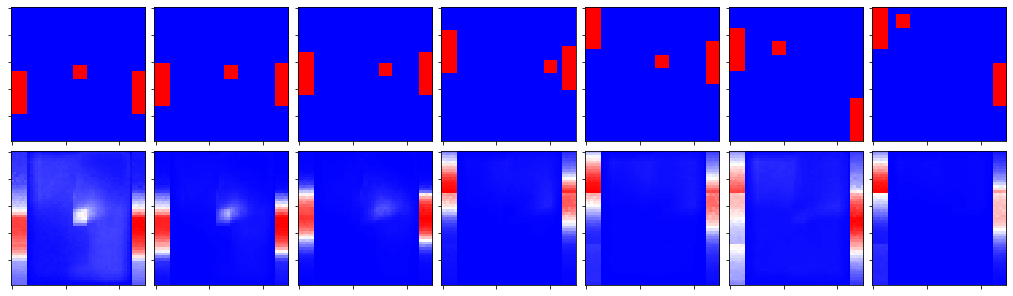

Epoch 6/150
100/100 [==============================] - 112s 1s/step - loss: 0.1787 - frames_loss: 0.1203 - lambda_13_loss: 0.0584 - frames_mean_squared_error: 0.0342 - frames_acc: 0.9530 - lambda_13_mean_squared_error: 2.6312 - lambda_13_acc: 0.9721 - val_loss: 0.1545 - val_frames_loss: 0.1133 - val_lambda_13_loss: 0.0412 - val_frames_mean_squared_error: 0.0321 - val_frames_acc: 0.9565 - val_lambda_13_mean_squared_error: 2.4769 - val_lambda_13_acc: 0.9856


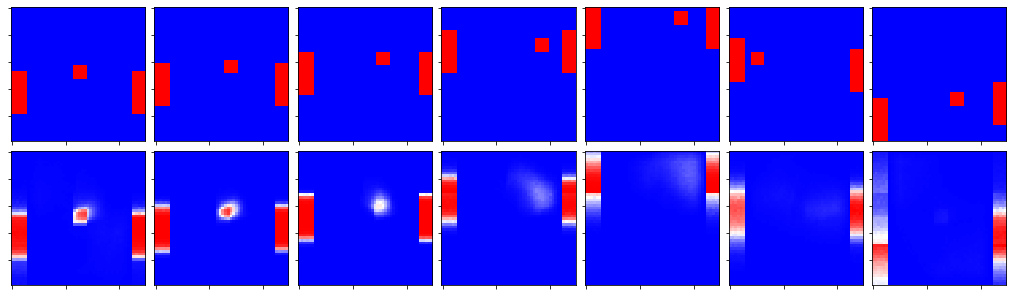

Epoch 7/150
100/100 [==============================] - 111s 1s/step - loss: 0.1559 - frames_loss: 0.1095 - lambda_13_loss: 0.0464 - frames_mean_squared_error: 0.0310 - frames_acc: 0.9578 - lambda_13_mean_squared_error: 4.3310 - lambda_13_acc: 0.9788 - val_loss: 0.1442 - val_frames_loss: 0.1065 - val_lambda_13_loss: 0.0377 - val_frames_mean_squared_error: 0.0298 - val_frames_acc: 0.9593 - val_lambda_13_mean_squared_error: 2.7161 - val_lambda_13_acc: 0.9807


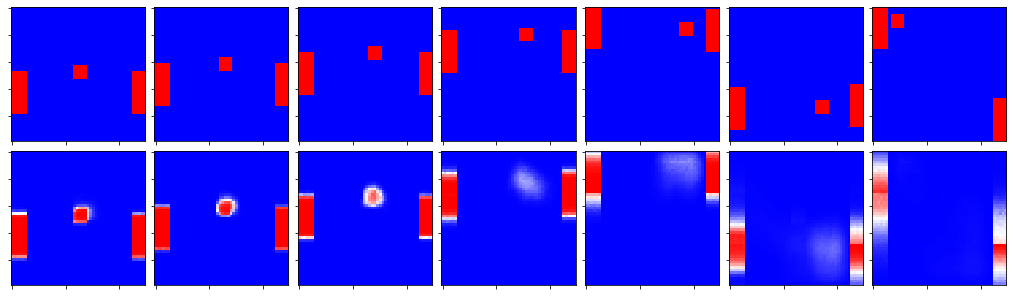

Epoch 8/150
100/100 [==============================] - 112s 1s/step - loss: 0.1477 - frames_loss: 0.0982 - lambda_13_loss: 0.0495 - frames_mean_squared_error: 0.0276 - frames_acc: 0.9623 - lambda_13_mean_squared_error: 4.4911 - lambda_13_acc: 0.9773 - val_loss: 0.1301 - val_frames_loss: 0.0893 - val_lambda_13_loss: 0.0409 - val_frames_mean_squared_error: 0.0253 - val_frames_acc: 0.9651 - val_lambda_13_mean_squared_error: 4.7957 - val_lambda_13_acc: 0.9799


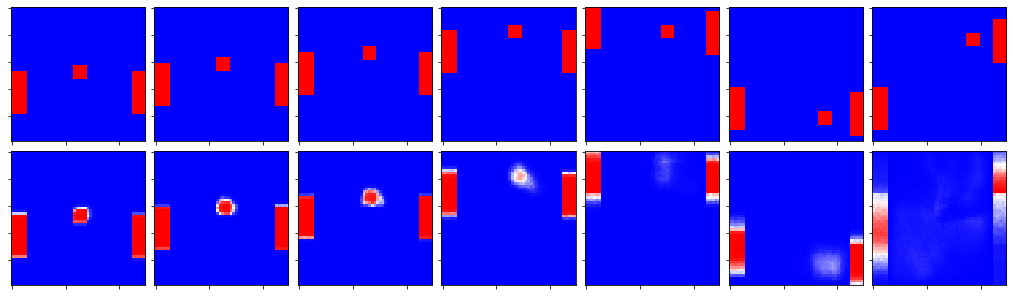

Epoch 9/150
100/100 [==============================] - 112s 1s/step - loss: 0.1517 - frames_loss: 0.1023 - lambda_13_loss: 0.0494 - frames_mean_squared_error: 0.0288 - frames_acc: 0.9611 - lambda_13_mean_squared_error: 3.9929 - lambda_13_acc: 0.9792 - val_loss: 0.1739 - val_frames_loss: 0.1144 - val_lambda_13_loss: 0.0595 - val_frames_mean_squared_error: 0.0316 - val_frames_acc: 0.9587 - val_lambda_13_mean_squared_error: 2.4660 - val_lambda_13_acc: 0.9686


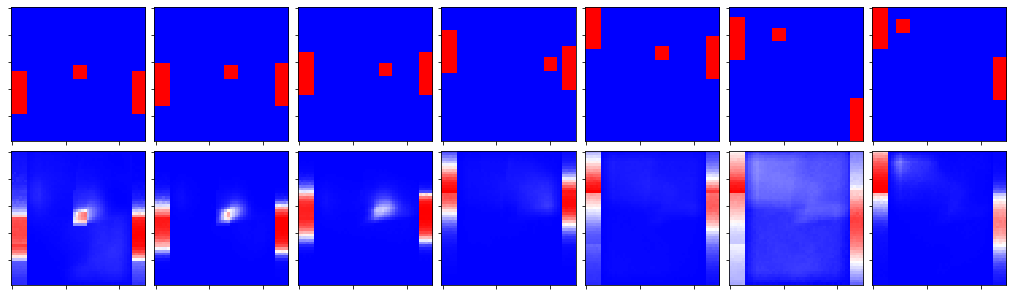

Epoch 10/150
100/100 [==============================] - 112s 1s/step - loss: 0.1683 - frames_loss: 0.1026 - lambda_13_loss: 0.0657 - frames_mean_squared_error: 0.0276 - frames_acc: 0.9636 - lambda_13_mean_squared_error: 7.2557 - lambda_13_acc: 0.9791 - val_loss: 0.3674 - val_frames_loss: 0.1336 - val_lambda_13_loss: 0.2338 - val_frames_mean_squared_error: 0.0373 - val_frames_acc: 0.9503 - val_lambda_13_mean_squared_error: 2.9656 - val_lambda_13_acc: 0.9553


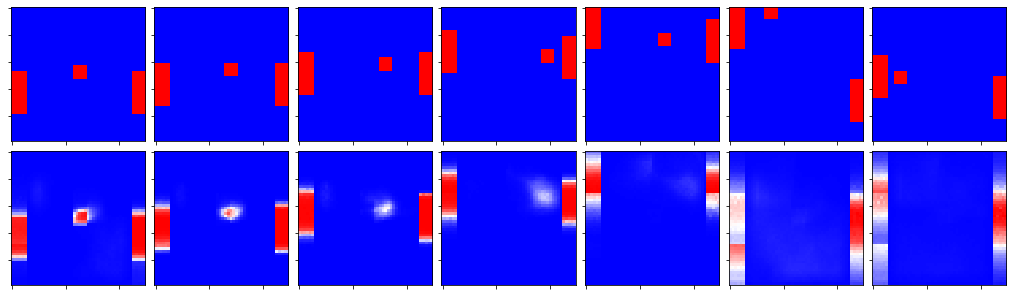

Epoch 11/150
100/100 [==============================] - 112s 1s/step - loss: 0.1448 - frames_loss: 0.0973 - lambda_13_loss: 0.0475 - frames_mean_squared_error: 0.0275 - frames_acc: 0.9632 - lambda_13_mean_squared_error: 2.4288 - lambda_13_acc: 0.9771 - val_loss: 0.0945 - val_frames_loss: 0.0813 - val_lambda_13_loss: 0.0132 - val_frames_mean_squared_error: 0.0232 - val_frames_acc: 0.9683 - val_lambda_13_mean_squared_error: 4.5111 - val_lambda_13_acc: 0.9963


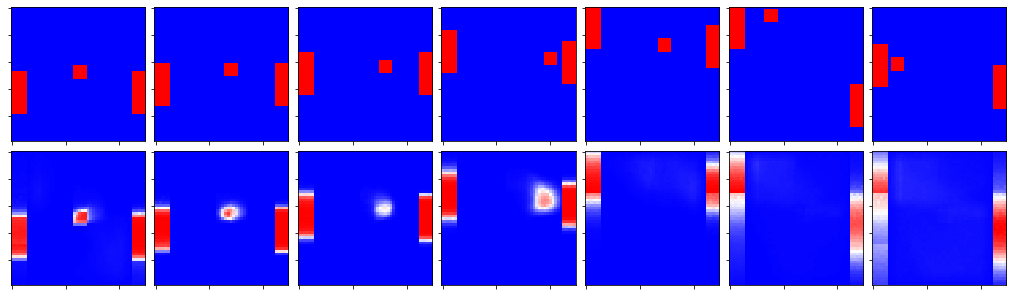

Epoch 12/150
100/100 [==============================] - 112s 1s/step - loss: 0.1324 - frames_loss: 0.0941 - lambda_13_loss: 0.0384 - frames_mean_squared_error: 0.0266 - frames_acc: 0.9642 - lambda_13_mean_squared_error: 2.3785 - lambda_13_acc: 0.9844 - val_loss: 0.1004 - val_frames_loss: 0.0802 - val_lambda_13_loss: 0.0201 - val_frames_mean_squared_error: 0.0226 - val_frames_acc: 0.9697 - val_lambda_13_mean_squared_error: 4.2057 - val_lambda_13_acc: 0.9938


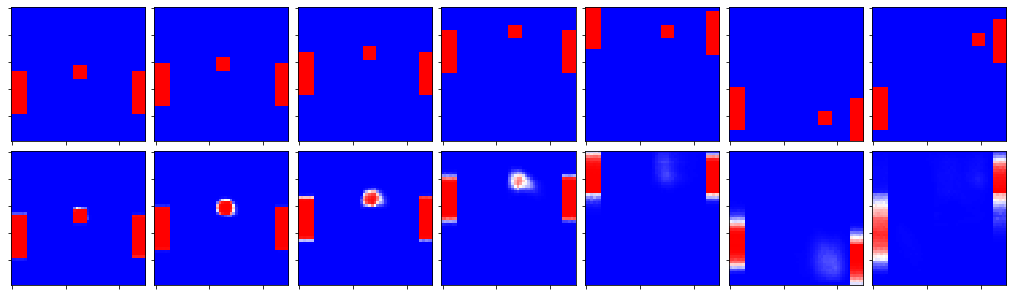

Epoch 13/150
100/100 [==============================] - 112s 1s/step - loss: 0.1374 - frames_loss: 0.0807 - lambda_13_loss: 0.0567 - frames_mean_squared_error: 0.0228 - frames_acc: 0.9698 - lambda_13_mean_squared_error: 4.3338 - lambda_13_acc: 0.9838 - val_loss: 0.0966 - val_frames_loss: 0.0748 - val_lambda_13_loss: 0.0218 - val_frames_mean_squared_error: 0.0212 - val_frames_acc: 0.9716 - val_lambda_13_mean_squared_error: 6.8344 - val_lambda_13_acc: 0.9906


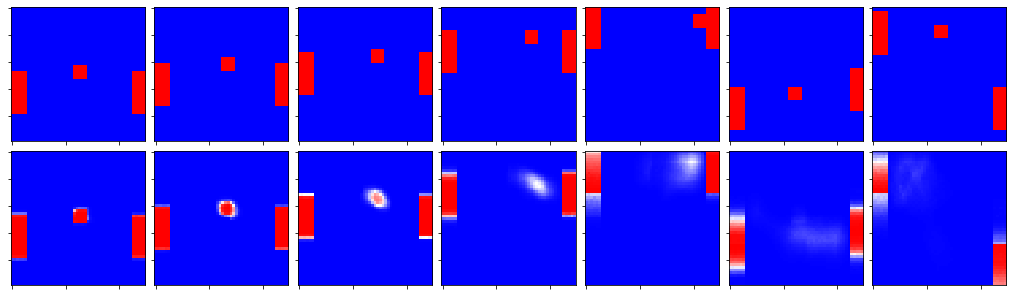

Epoch 14/150
100/100 [==============================] - 111s 1s/step - loss: 0.1192 - frames_loss: 0.0768 - lambda_13_loss: 0.0424 - frames_mean_squared_error: 0.0215 - frames_acc: 0.9716 - lambda_13_mean_squared_error: 6.2436 - lambda_13_acc: 0.9857 - val_loss: 0.1316 - val_frames_loss: 0.0812 - val_lambda_13_loss: 0.0504 - val_frames_mean_squared_error: 0.0229 - val_frames_acc: 0.9697 - val_lambda_13_mean_squared_error: 3.3073 - val_lambda_13_acc: 0.9727


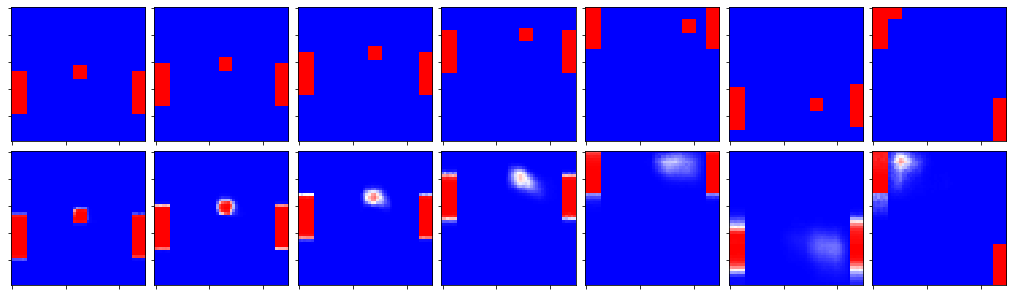

Epoch 15/150
100/100 [==============================] - 112s 1s/step - loss: 0.1416 - frames_loss: 0.0808 - lambda_13_loss: 0.0609 - frames_mean_squared_error: 0.0225 - frames_acc: 0.9704 - lambda_13_mean_squared_error: 4.6951 - lambda_13_acc: 0.9803 - val_loss: 0.1131 - val_frames_loss: 0.0797 - val_lambda_13_loss: 0.0334 - val_frames_mean_squared_error: 0.0222 - val_frames_acc: 0.9708 - val_lambda_13_mean_squared_error: 3.6145 - val_lambda_13_acc: 0.9873


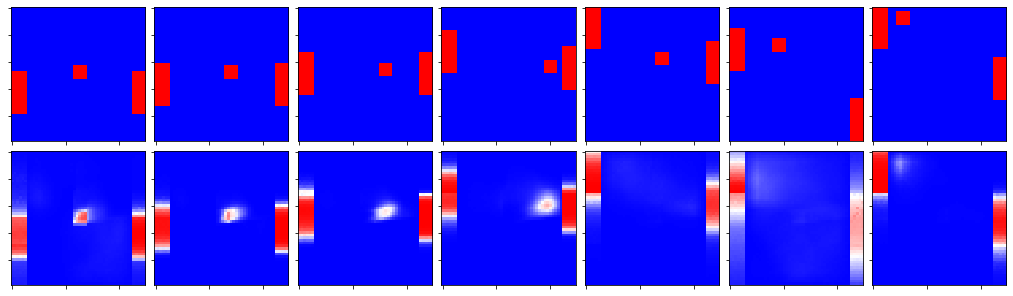

Epoch 16/150
100/100 [==============================] - 112s 1s/step - loss: 0.1087 - frames_loss: 0.0736 - lambda_13_loss: 0.0350 - frames_mean_squared_error: 0.0204 - frames_acc: 0.9733 - lambda_13_mean_squared_error: 4.6471 - lambda_13_acc: 0.9847 - val_loss: 0.0989 - val_frames_loss: 0.0724 - val_lambda_13_loss: 0.0264 - val_frames_mean_squared_error: 0.0202 - val_frames_acc: 0.9737 - val_lambda_13_mean_squared_error: 4.6763 - val_lambda_13_acc: 0.9891


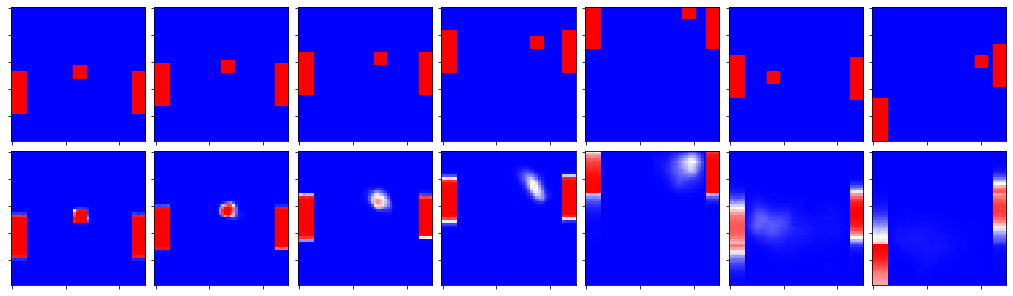

Epoch 17/150
100/100 [==============================] - 111s 1s/step - loss: 0.1387 - frames_loss: 0.0760 - lambda_13_loss: 0.0628 - frames_mean_squared_error: 0.0213 - frames_acc: 0.9721 - lambda_13_mean_squared_error: 5.5650 - lambda_13_acc: 0.9816 - val_loss: 0.0873 - val_frames_loss: 0.0659 - val_lambda_13_loss: 0.0214 - val_frames_mean_squared_error: 0.0186 - val_frames_acc: 0.9755 - val_lambda_13_mean_squared_error: 6.3609 - val_lambda_13_acc: 0.9944


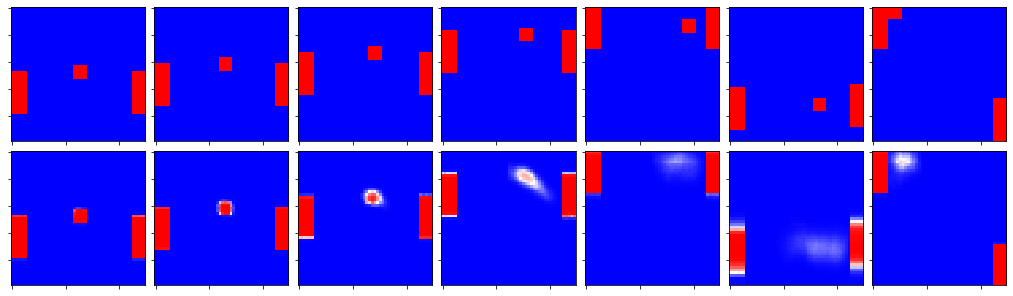

Epoch 18/150
100/100 [==============================] - 112s 1s/step - loss: 0.1712 - frames_loss: 0.0899 - lambda_13_loss: 0.0813 - frames_mean_squared_error: 0.0250 - frames_acc: 0.9671 - lambda_13_mean_squared_error: 4.9278 - lambda_13_acc: 0.9765 - val_loss: 0.1555 - val_frames_loss: 0.0935 - val_lambda_13_loss: 0.0620 - val_frames_mean_squared_error: 0.0263 - val_frames_acc: 0.9647 - val_lambda_13_mean_squared_error: 2.1062 - val_lambda_13_acc: 0.9730


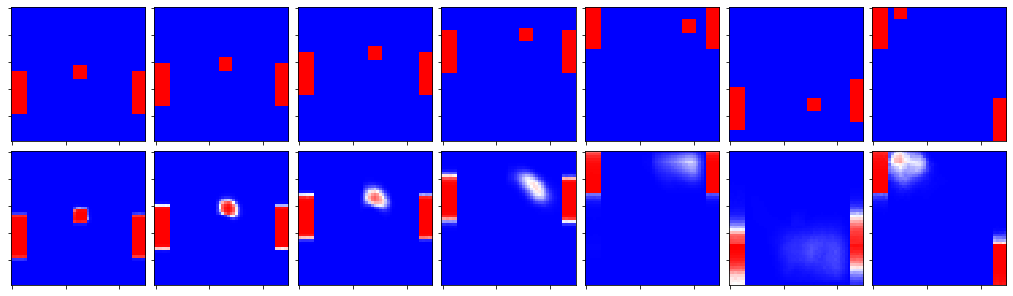

Epoch 19/150
100/100 [==============================] - 112s 1s/step - loss: 0.1098 - frames_loss: 0.0726 - lambda_13_loss: 0.0373 - frames_mean_squared_error: 0.0203 - frames_acc: 0.9734 - lambda_13_mean_squared_error: 7.2766 - lambda_13_acc: 0.9841 - val_loss: 0.1058 - val_frames_loss: 0.0648 - val_lambda_13_loss: 0.0409 - val_frames_mean_squared_error: 0.0182 - val_frames_acc: 0.9764 - val_lambda_13_mean_squared_error: 9.8237 - val_lambda_13_acc: 0.9766


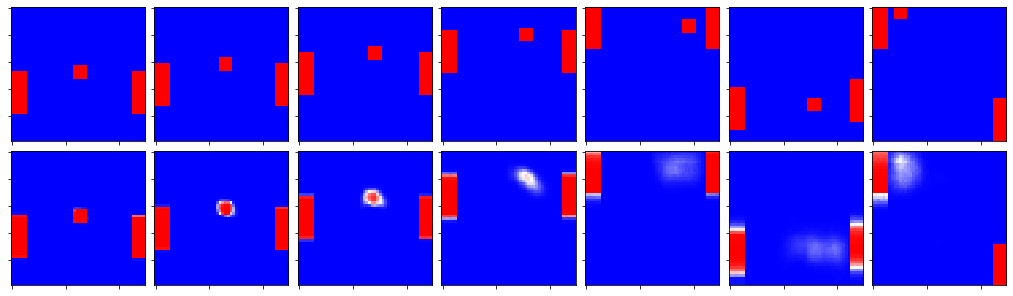

Epoch 20/150
100/100 [==============================] - 112s 1s/step - loss: 0.3500 - frames_loss: 0.0886 - lambda_13_loss: 0.2614 - frames_mean_squared_error: 0.0247 - frames_acc: 0.9673 - lambda_13_mean_squared_error: 9.3732 - lambda_13_acc: 0.9708 - val_loss: 0.3964 - val_frames_loss: 0.0748 - val_lambda_13_loss: 0.3216 - val_frames_mean_squared_error: 0.0213 - val_frames_acc: 0.9714 - val_lambda_13_mean_squared_error: 8.7577 - val_lambda_13_acc: 0.9702


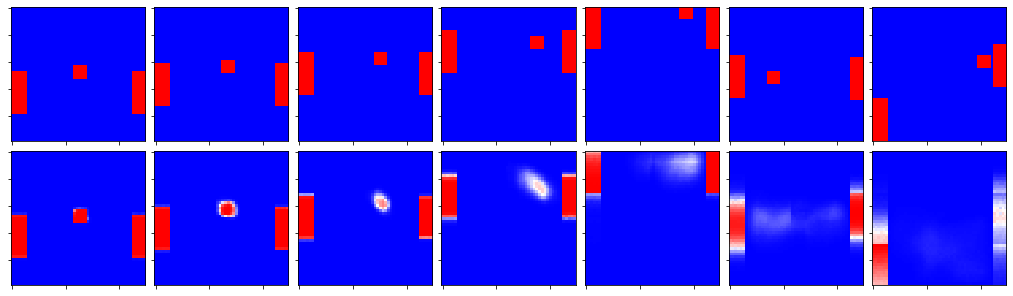

Epoch 21/150
100/100 [==============================] - 112s 1s/step - loss: 0.3144 - frames_loss: 0.0669 - lambda_13_loss: 0.2474 - frames_mean_squared_error: 0.0190 - frames_acc: 0.9748 - lambda_13_mean_squared_error: 10.0709 - lambda_13_acc: 0.9745 - val_loss: 0.3344 - val_frames_loss: 0.0601 - val_lambda_13_loss: 0.2744 - val_frames_mean_squared_error: 0.0172 - val_frames_acc: 0.9773 - val_lambda_13_mean_squared_error: 13.5764 - val_lambda_13_acc: 0.9773


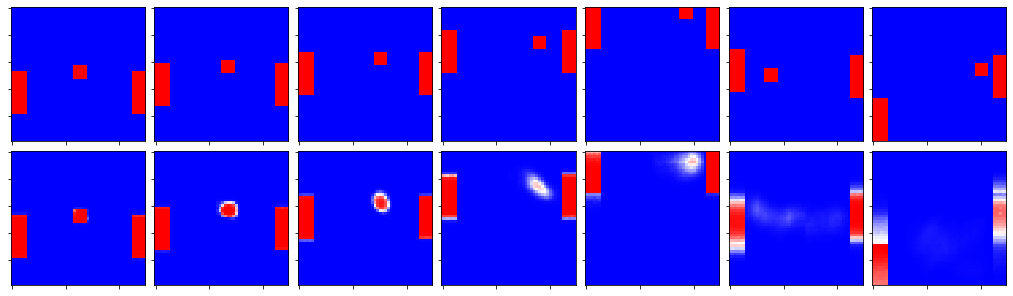

Epoch 22/150
100/100 [==============================] - 111s 1s/step - loss: 0.2850 - frames_loss: 0.0594 - lambda_13_loss: 0.2256 - frames_mean_squared_error: 0.0169 - frames_acc: 0.9780 - lambda_13_mean_squared_error: 13.2666 - lambda_13_acc: 0.9781 - val_loss: 0.2952 - val_frames_loss: 0.0612 - val_lambda_13_loss: 0.2340 - val_frames_mean_squared_error: 0.0172 - val_frames_acc: 0.9779 - val_lambda_13_mean_squared_error: 11.2648 - val_lambda_13_acc: 0.9772


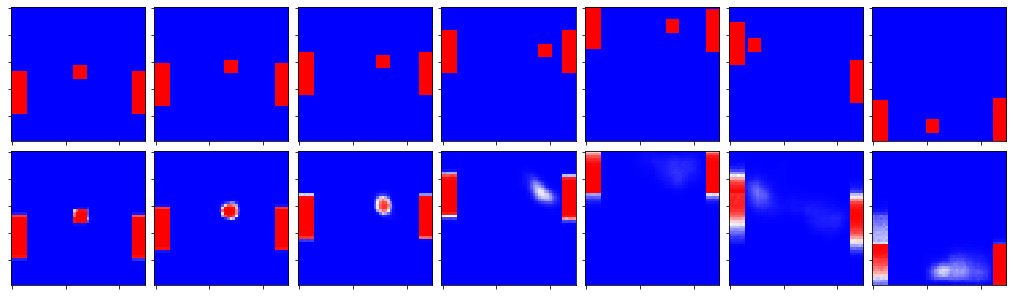

Epoch 23/150
100/100 [==============================] - 112s 1s/step - loss: 0.2836 - frames_loss: 0.0511 - lambda_13_loss: 0.2325 - frames_mean_squared_error: 0.0145 - frames_acc: 0.9811 - lambda_13_mean_squared_error: 19.5780 - lambda_13_acc: 0.9807 - val_loss: 0.5646 - val_frames_loss: 0.0482 - val_lambda_13_loss: 0.5164 - val_frames_mean_squared_error: 0.0136 - val_frames_acc: 0.9823 - val_lambda_13_mean_squared_error: 20.2050 - val_lambda_13_acc: 0.9630


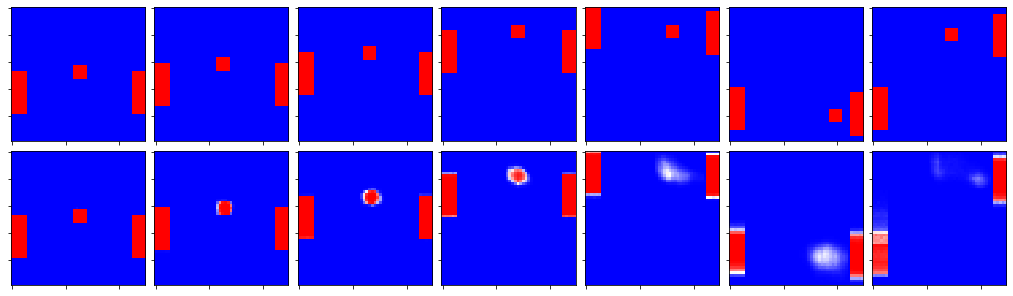

Epoch 24/150
100/100 [==============================] - 112s 1s/step - loss: 0.2901 - frames_loss: 0.0472 - lambda_13_loss: 0.2429 - frames_mean_squared_error: 0.0135 - frames_acc: 0.9823 - lambda_13_mean_squared_error: 21.2597 - lambda_13_acc: 0.9804 - val_loss: 0.2725 - val_frames_loss: 0.0431 - val_lambda_13_loss: 0.2294 - val_frames_mean_squared_error: 0.0124 - val_frames_acc: 0.9836 - val_lambda_13_mean_squared_error: 22.9952 - val_lambda_13_acc: 0.9766


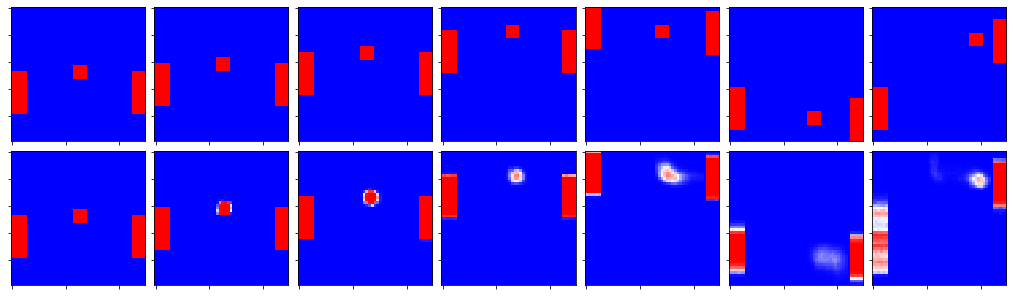

Epoch 25/150
100/100 [==============================] - 112s 1s/step - loss: 0.2422 - frames_loss: 0.0421 - lambda_13_loss: 0.2001 - frames_mean_squared_error: 0.0121 - frames_acc: 0.9840 - lambda_13_mean_squared_error: 23.6012 - lambda_13_acc: 0.9831 - val_loss: 0.3491 - val_frames_loss: 0.0387 - val_lambda_13_loss: 0.3104 - val_frames_mean_squared_error: 0.0111 - val_frames_acc: 0.9853 - val_lambda_13_mean_squared_error: 29.2173 - val_lambda_13_acc: 0.9780


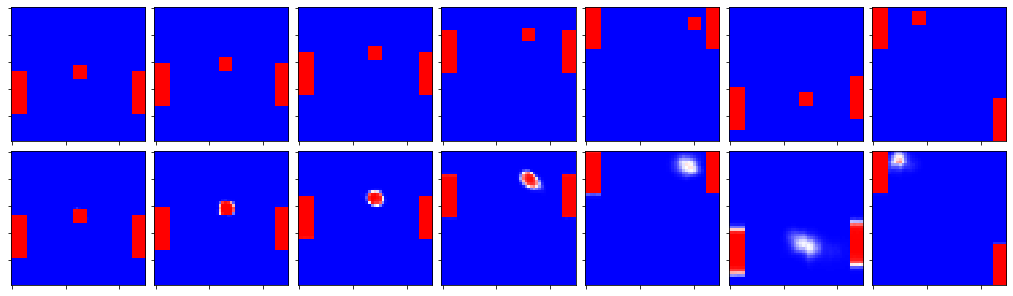

Epoch 26/150
100/100 [==============================] - 112s 1s/step - loss: 0.5953 - frames_loss: 0.1036 - lambda_13_loss: 0.4917 - frames_mean_squared_error: 0.0252 - frames_acc: 0.9683 - lambda_13_mean_squared_error: 37.1250 - lambda_13_acc: 0.9653 - val_loss: 0.6965 - val_frames_loss: 0.0639 - val_lambda_13_loss: 0.6327 - val_frames_mean_squared_error: 0.0179 - val_frames_acc: 0.9769 - val_lambda_13_mean_squared_error: 45.8433 - val_lambda_13_acc: 0.9590


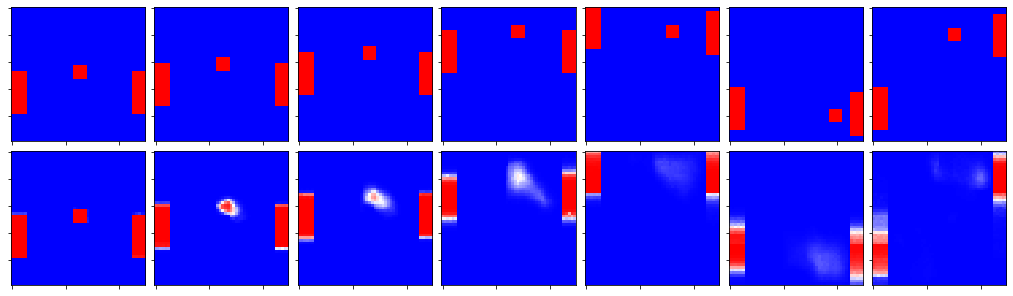

Epoch 27/150
100/100 [==============================] - 111s 1s/step - loss: 0.6478 - frames_loss: 0.0520 - lambda_13_loss: 0.5958 - frames_mean_squared_error: 0.0147 - frames_acc: 0.9811 - lambda_13_mean_squared_error: 60.1252 - lambda_13_acc: 0.9614 - val_loss: 0.5795 - val_frames_loss: 0.0429 - val_lambda_13_loss: 0.5366 - val_frames_mean_squared_error: 0.0123 - val_frames_acc: 0.9838 - val_lambda_13_mean_squared_error: 83.4638 - val_lambda_13_acc: 0.9652


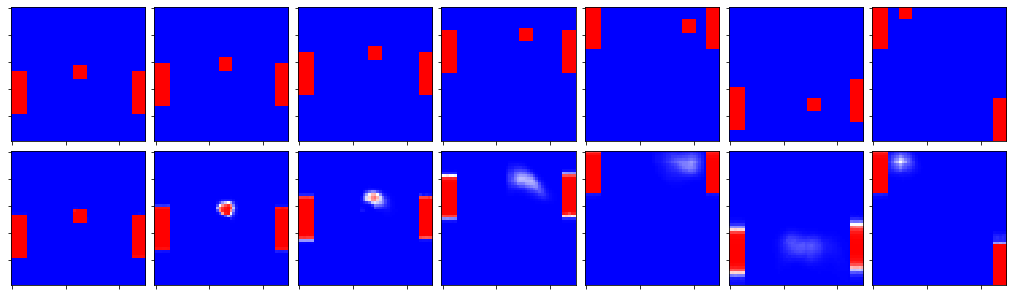

Epoch 28/150
100/100 [==============================] - 111s 1s/step - loss: 0.5833 - frames_loss: 0.0400 - lambda_13_loss: 0.5433 - frames_mean_squared_error: 0.0116 - frames_acc: 0.9847 - lambda_13_mean_squared_error: 92.9048 - lambda_13_acc: 0.9648 - val_loss: 0.5515 - val_frames_loss: 0.0374 - val_lambda_13_loss: 0.5140 - val_frames_mean_squared_error: 0.0110 - val_frames_acc: 0.9853 - val_lambda_13_mean_squared_error: 106.1547 - val_lambda_13_acc: 0.9667


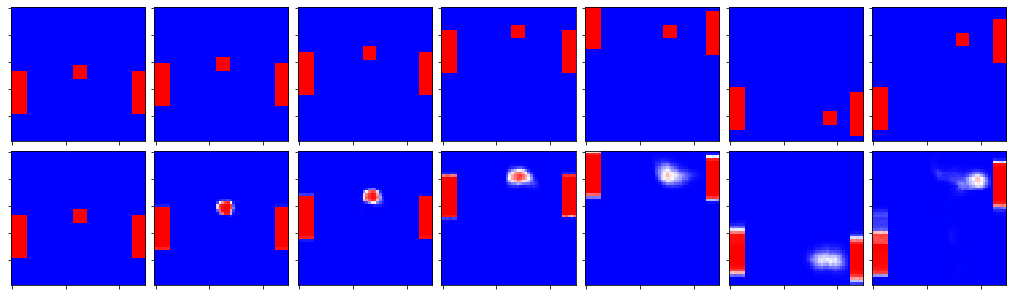

Epoch 29/150
100/100 [==============================] - 112s 1s/step - loss: 0.5872 - frames_loss: 0.0342 - lambda_13_loss: 0.5530 - frames_mean_squared_error: 0.0101 - frames_acc: 0.9863 - lambda_13_mean_squared_error: 123.8453 - lambda_13_acc: 0.9642 - val_loss: 0.6183 - val_frames_loss: 0.0346 - val_lambda_13_loss: 0.5837 - val_frames_mean_squared_error: 0.0103 - val_frames_acc: 0.9859 - val_lambda_13_mean_squared_error: 123.6983 - val_lambda_13_acc: 0.9622


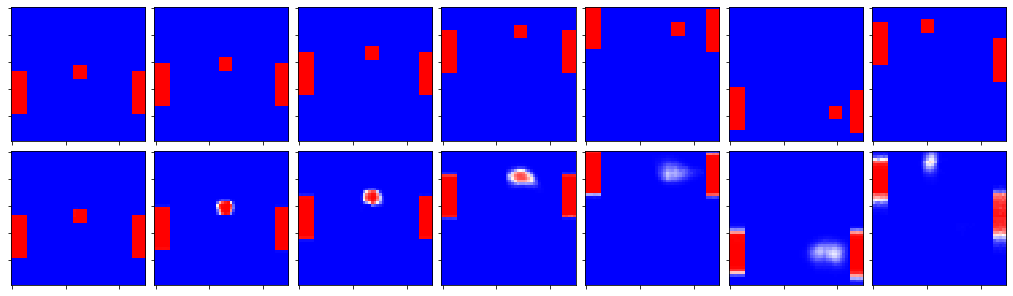

Epoch 30/150
100/100 [==============================] - 112s 1s/step - loss: 0.5811 - frames_loss: 0.0300 - lambda_13_loss: 0.5511 - frames_mean_squared_error: 0.0089 - frames_acc: 0.9876 - lambda_13_mean_squared_error: 151.5055 - lambda_13_acc: 0.9643 - val_loss: 0.5933 - val_frames_loss: 0.0284 - val_lambda_13_loss: 0.5649 - val_frames_mean_squared_error: 0.0085 - val_frames_acc: 0.9881 - val_lambda_13_mean_squared_error: 156.1156 - val_lambda_13_acc: 0.9634


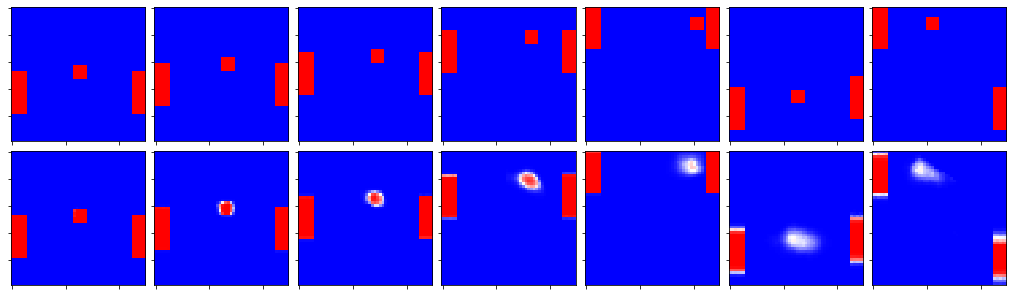

Epoch 31/150
100/100 [==============================] - 112s 1s/step - loss: 0.6243 - frames_loss: 0.0262 - lambda_13_loss: 0.5981 - frames_mean_squared_error: 0.0079 - frames_acc: 0.9890 - lambda_13_mean_squared_error: 185.5785 - lambda_13_acc: 0.9612 - val_loss: 0.5907 - val_frames_loss: 0.0258 - val_lambda_13_loss: 0.5649 - val_frames_mean_squared_error: 0.0078 - val_frames_acc: 0.9890 - val_lambda_13_mean_squared_error: 203.7133 - val_lambda_13_acc: 0.9634


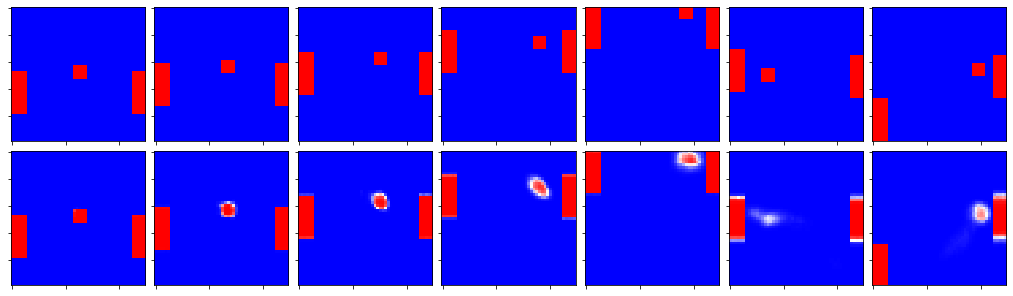

Epoch 32/150
100/100 [==============================] - 112s 1s/step - loss: 0.5848 - frames_loss: 0.0251 - lambda_13_loss: 0.5598 - frames_mean_squared_error: 0.0076 - frames_acc: 0.9893 - lambda_13_mean_squared_error: 209.2636 - lambda_13_acc: 0.9637 - val_loss: 0.3780 - val_frames_loss: 0.0259 - val_lambda_13_loss: 0.3521 - val_frames_mean_squared_error: 0.0079 - val_frames_acc: 0.9889 - val_lambda_13_mean_squared_error: 205.4043 - val_lambda_13_acc: 0.9772


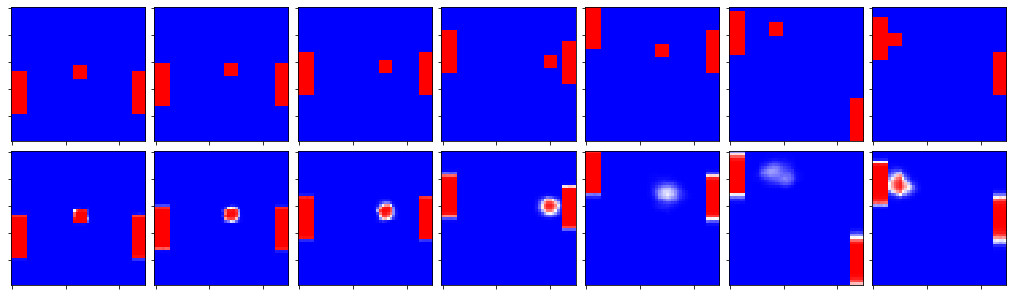

Epoch 33/150
100/100 [==============================] - 112s 1s/step - loss: 0.5389 - frames_loss: 0.0235 - lambda_13_loss: 0.5154 - frames_mean_squared_error: 0.0071 - frames_acc: 0.9899 - lambda_13_mean_squared_error: 212.3006 - lambda_13_acc: 0.9666 - val_loss: 0.4385 - val_frames_loss: 0.0243 - val_lambda_13_loss: 0.4142 - val_frames_mean_squared_error: 0.0074 - val_frames_acc: 0.9895 - val_lambda_13_mean_squared_error: 225.9624 - val_lambda_13_acc: 0.9731


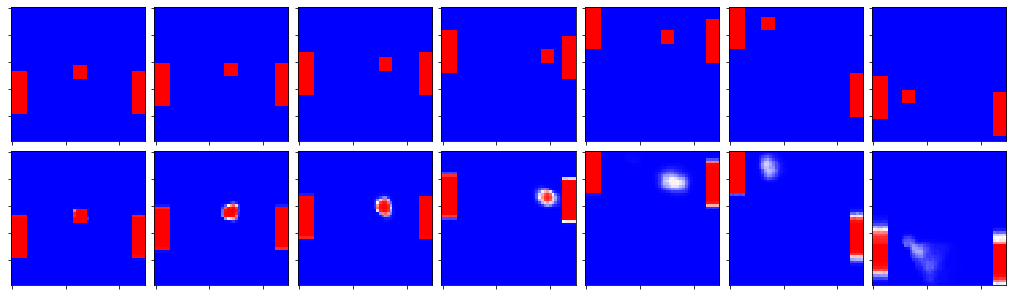

Epoch 34/150
100/100 [==============================] - 112s 1s/step - loss: 0.6061 - frames_loss: 0.0213 - lambda_13_loss: 0.5847 - frames_mean_squared_error: 0.0065 - frames_acc: 0.9909 - lambda_13_mean_squared_error: 228.9706 - lambda_13_acc: 0.9621 - val_loss: 0.3961 - val_frames_loss: 0.0214 - val_lambda_13_loss: 0.3747 - val_frames_mean_squared_error: 0.0065 - val_frames_acc: 0.9908 - val_lambda_13_mean_squared_error: 252.7788 - val_lambda_13_acc: 0.9757


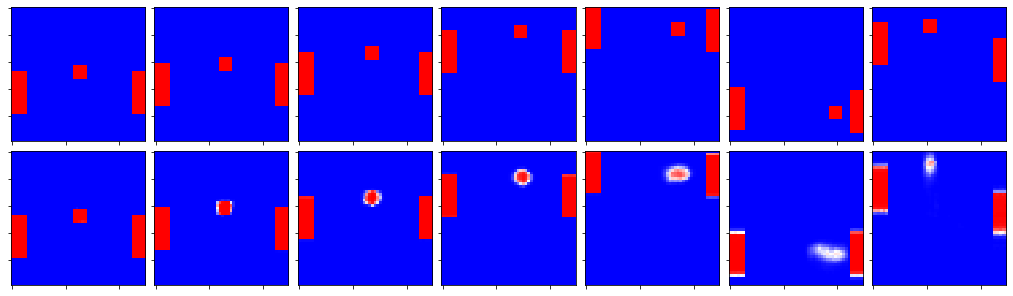

Epoch 35/150
100/100 [==============================] - 112s 1s/step - loss: 0.5702 - frames_loss: 0.0197 - lambda_13_loss: 0.5506 - frames_mean_squared_error: 0.0060 - frames_acc: 0.9917 - lambda_13_mean_squared_error: 261.7560 - lambda_13_acc: 0.9643 - val_loss: 0.8420 - val_frames_loss: 0.0191 - val_lambda_13_loss: 0.8228 - val_frames_mean_squared_error: 0.0058 - val_frames_acc: 0.9919 - val_lambda_13_mean_squared_error: 261.1955 - val_lambda_13_acc: 0.9467


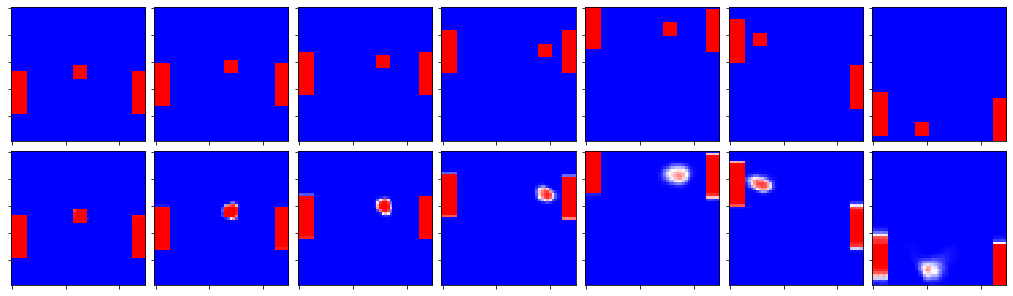

Epoch 36/150
100/100 [==============================] - 112s 1s/step - loss: 0.5632 - frames_loss: 0.0196 - lambda_13_loss: 0.5435 - frames_mean_squared_error: 0.0060 - frames_acc: 0.9917 - lambda_13_mean_squared_error: 275.2693 - lambda_13_acc: 0.9648 - val_loss: 0.5166 - val_frames_loss: 0.0195 - val_lambda_13_loss: 0.4971 - val_frames_mean_squared_error: 0.0059 - val_frames_acc: 0.9916 - val_lambda_13_mean_squared_error: 242.3307 - val_lambda_13_acc: 0.9678


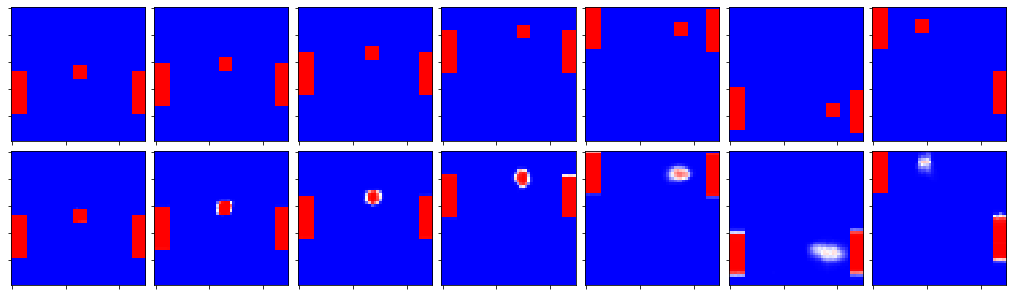

Epoch 37/150
100/100 [==============================] - 112s 1s/step - loss: 0.5892 - frames_loss: 0.0179 - lambda_13_loss: 0.5713 - frames_mean_squared_error: 0.0054 - frames_acc: 0.9925 - lambda_13_mean_squared_error: 269.3517 - lambda_13_acc: 0.9630 - val_loss: 0.4669 - val_frames_loss: 0.0168 - val_lambda_13_loss: 0.4500 - val_frames_mean_squared_error: 0.0051 - val_frames_acc: 0.9930 - val_lambda_13_mean_squared_error: 292.6204 - val_lambda_13_acc: 0.9708


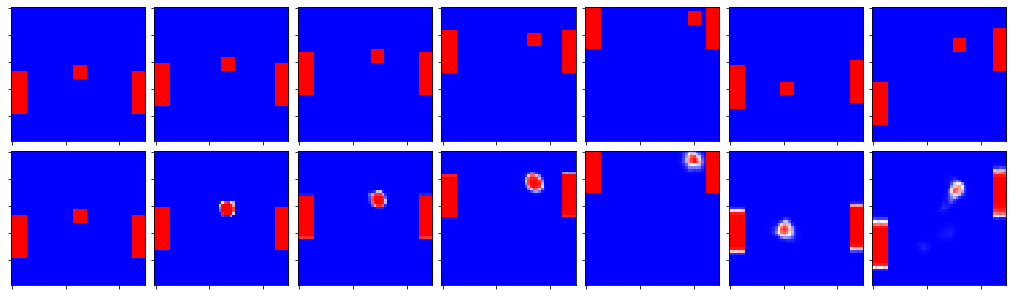

Epoch 38/150
100/100 [==============================] - 111s 1s/step - loss: 0.5984 - frames_loss: 0.0169 - lambda_13_loss: 0.5814 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_13_mean_squared_error: 298.8846 - lambda_13_acc: 0.9623 - val_loss: 0.5552 - val_frames_loss: 0.0166 - val_lambda_13_loss: 0.5385 - val_frames_mean_squared_error: 0.0050 - val_frames_acc: 0.9931 - val_lambda_13_mean_squared_error: 282.3979 - val_lambda_13_acc: 0.9651


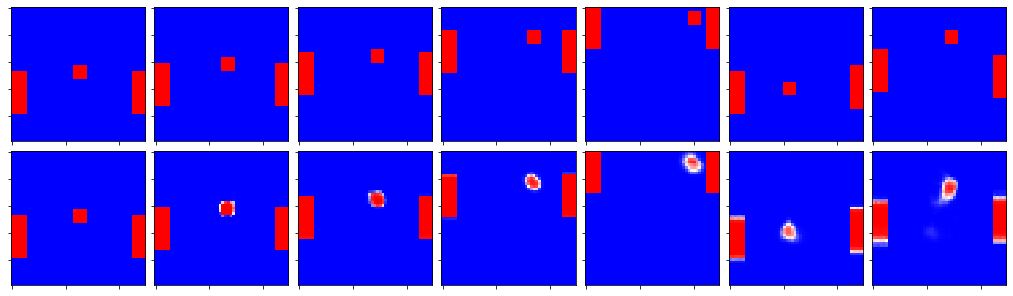

Epoch 39/150
100/100 [==============================] - 112s 1s/step - loss: 0.5926 - frames_loss: 0.0170 - lambda_13_loss: 0.5756 - frames_mean_squared_error: 0.0051 - frames_acc: 0.9929 - lambda_13_mean_squared_error: 302.9155 - lambda_13_acc: 0.9627 - val_loss: 0.5337 - val_frames_loss: 0.0159 - val_lambda_13_loss: 0.5178 - val_frames_mean_squared_error: 0.0048 - val_frames_acc: 0.9934 - val_lambda_13_mean_squared_error: 291.1069 - val_lambda_13_acc: 0.9664


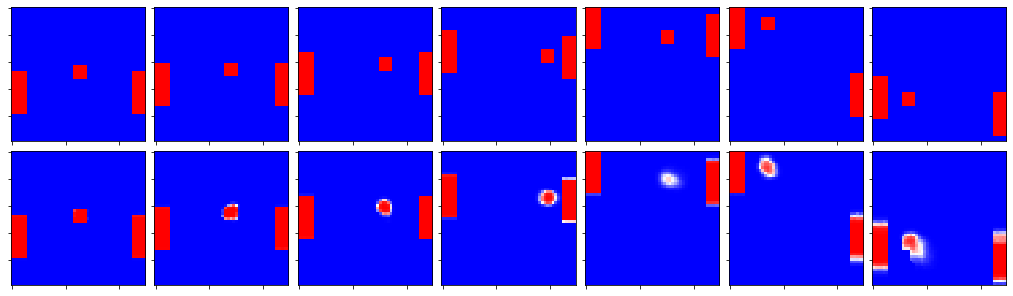

Epoch 40/150
100/100 [==============================] - 112s 1s/step - loss: 0.5879 - frames_loss: 0.0162 - lambda_13_loss: 0.5717 - frames_mean_squared_error: 0.0049 - frames_acc: 0.9933 - lambda_13_mean_squared_error: 302.1581 - lambda_13_acc: 0.9629 - val_loss: 0.4762 - val_frames_loss: 0.0149 - val_lambda_13_loss: 0.4613 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9940 - val_lambda_13_mean_squared_error: 318.5569 - val_lambda_13_acc: 0.9701


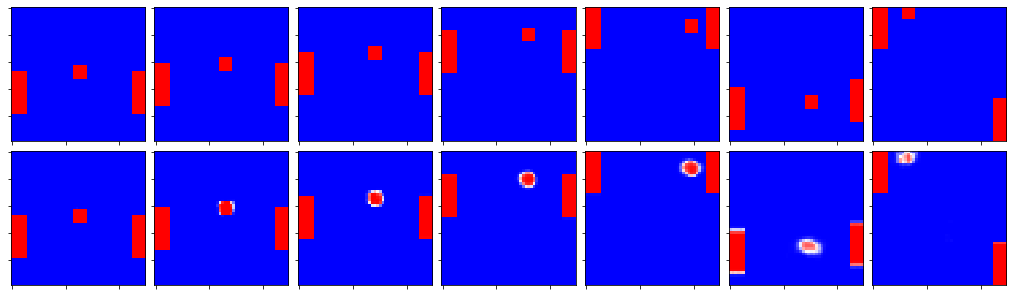

Epoch 41/150
100/100 [==============================] - 112s 1s/step - loss: 0.5966 - frames_loss: 0.0156 - lambda_13_loss: 0.5810 - frames_mean_squared_error: 0.0047 - frames_acc: 0.9935 - lambda_13_mean_squared_error: 320.2046 - lambda_13_acc: 0.9623 - val_loss: 0.7771 - val_frames_loss: 0.0145 - val_lambda_13_loss: 0.7626 - val_frames_mean_squared_error: 0.0044 - val_frames_acc: 0.9941 - val_lambda_13_mean_squared_error: 321.1608 - val_lambda_13_acc: 0.9506


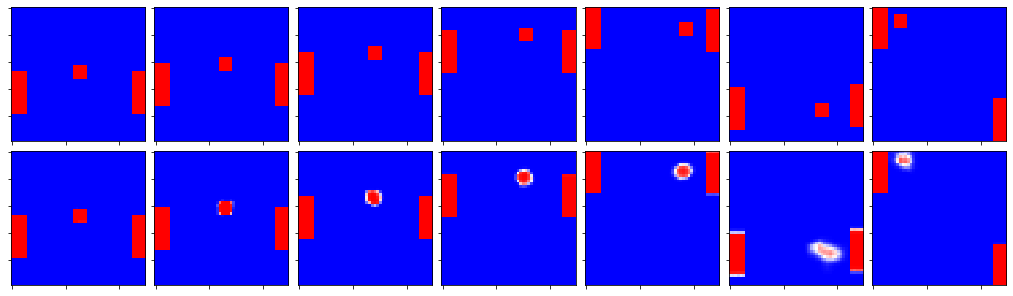

Epoch 42/150
100/100 [==============================] - 112s 1s/step - loss: 0.5653 - frames_loss: 0.0144 - lambda_13_loss: 0.5509 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9941 - lambda_13_mean_squared_error: 332.6010 - lambda_13_acc: 0.9643 - val_loss: 0.3754 - val_frames_loss: 0.0139 - val_lambda_13_loss: 0.3615 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9943 - val_lambda_13_mean_squared_error: 361.5835 - val_lambda_13_acc: 0.9766


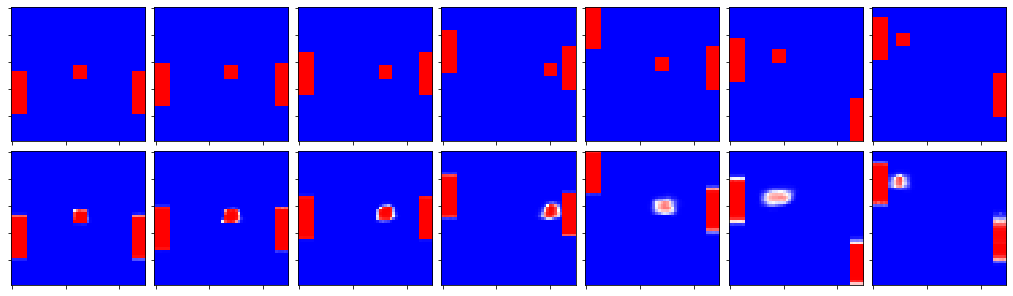

Epoch 43/150
100/100 [==============================] - 112s 1s/step - loss: 0.5947 - frames_loss: 0.0143 - lambda_13_loss: 0.5803 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9941 - lambda_13_mean_squared_error: 343.9139 - lambda_13_acc: 0.9624 - val_loss: 0.6873 - val_frames_loss: 0.0132 - val_lambda_13_loss: 0.6741 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9946 - val_lambda_13_mean_squared_error: 363.2812 - val_lambda_13_acc: 0.9563


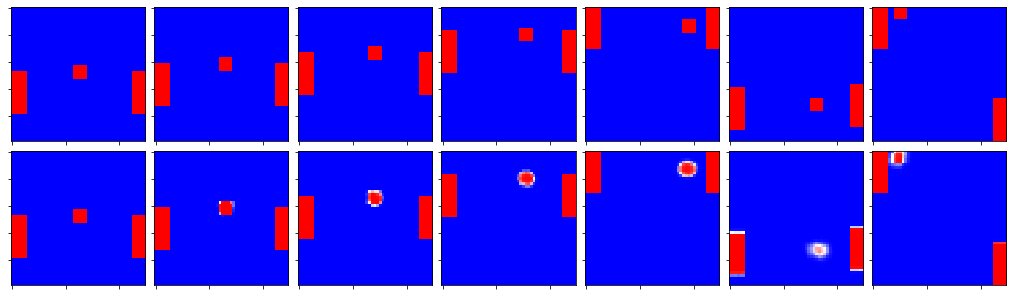

Epoch 44/150
100/100 [==============================] - 112s 1s/step - loss: 0.5719 - frames_loss: 0.0145 - lambda_13_loss: 0.5574 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9940 - lambda_13_mean_squared_error: 350.3137 - lambda_13_acc: 0.9639 - val_loss: 0.4889 - val_frames_loss: 0.0144 - val_lambda_13_loss: 0.4745 - val_frames_mean_squared_error: 0.0043 - val_frames_acc: 0.9941 - val_lambda_13_mean_squared_error: 318.8034 - val_lambda_13_acc: 0.9692


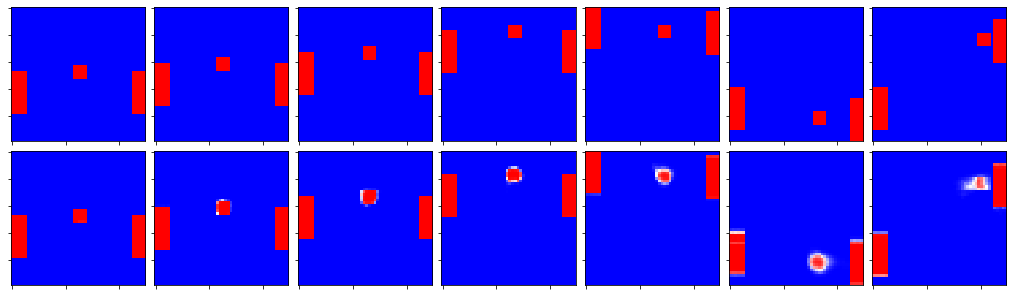

Epoch 45/150
100/100 [==============================] - 112s 1s/step - loss: 0.6269 - frames_loss: 0.0139 - lambda_13_loss: 0.6130 - frames_mean_squared_error: 0.0042 - frames_acc: 0.9943 - lambda_13_mean_squared_error: 344.8254 - lambda_13_acc: 0.9603 - val_loss: 0.5589 - val_frames_loss: 0.0147 - val_lambda_13_loss: 0.5442 - val_frames_mean_squared_error: 0.0045 - val_frames_acc: 0.9938 - val_lambda_13_mean_squared_error: 370.9616 - val_lambda_13_acc: 0.9647


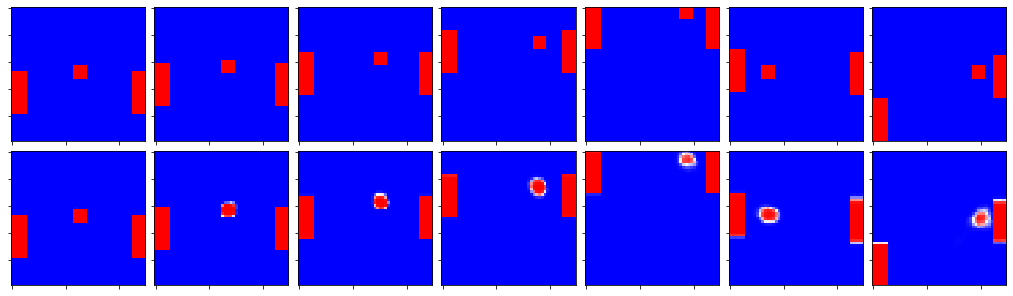

Epoch 46/150
100/100 [==============================] - 112s 1s/step - loss: 0.5319 - frames_loss: 0.0127 - lambda_13_loss: 0.5191 - frames_mean_squared_error: 0.0038 - frames_acc: 0.9948 - lambda_13_mean_squared_error: 363.9544 - lambda_13_acc: 0.9663 - val_loss: 0.6036 - val_frames_loss: 0.0124 - val_lambda_13_loss: 0.5912 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_13_mean_squared_error: 384.2752 - val_lambda_13_acc: 0.9617


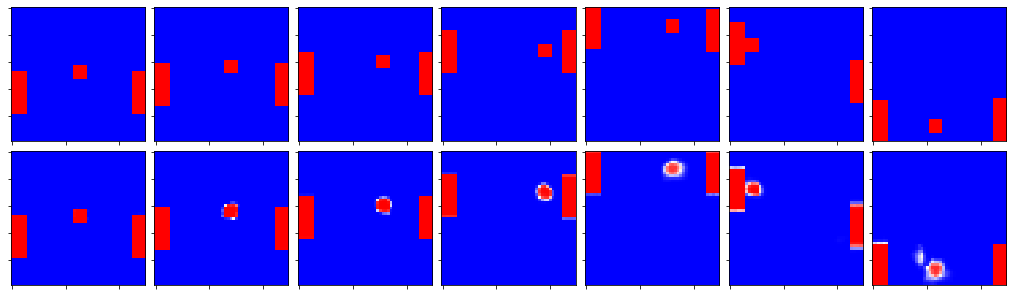

Epoch 47/150
100/100 [==============================] - 112s 1s/step - loss: 0.5822 - frames_loss: 0.0145 - lambda_13_loss: 0.5677 - frames_mean_squared_error: 0.0044 - frames_acc: 0.9940 - lambda_13_mean_squared_error: 342.0040 - lambda_13_acc: 0.9632 - val_loss: 0.6061 - val_frames_loss: 0.0130 - val_lambda_13_loss: 0.5931 - val_frames_mean_squared_error: 0.0039 - val_frames_acc: 0.9947 - val_lambda_13_mean_squared_error: 326.4795 - val_lambda_13_acc: 0.9615


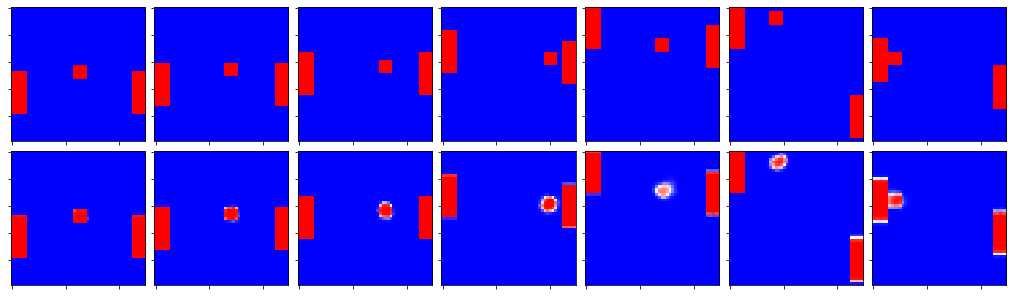

Epoch 48/150
100/100 [==============================] - 112s 1s/step - loss: 0.5896 - frames_loss: 0.0141 - lambda_13_loss: 0.5755 - frames_mean_squared_error: 0.0043 - frames_acc: 0.9942 - lambda_13_mean_squared_error: 328.6222 - lambda_13_acc: 0.9627 - val_loss: 0.6221 - val_frames_loss: 0.0139 - val_lambda_13_loss: 0.6082 - val_frames_mean_squared_error: 0.0042 - val_frames_acc: 0.9941 - val_lambda_13_mean_squared_error: 340.9893 - val_lambda_13_acc: 0.9606


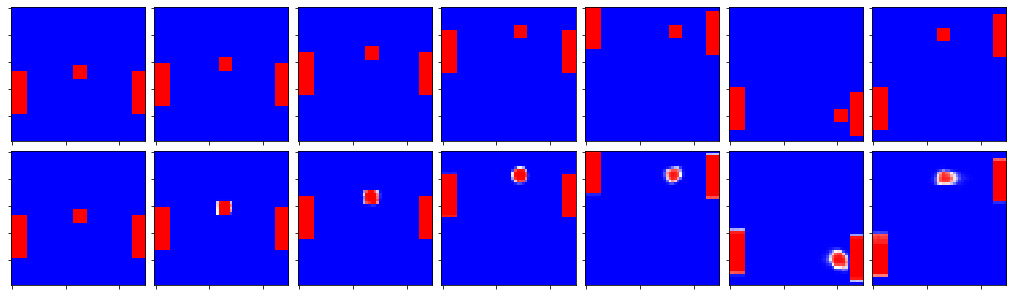

Epoch 49/150
100/100 [==============================] - 112s 1s/step - loss: 0.6456 - frames_loss: 0.0122 - lambda_13_loss: 0.6334 - frames_mean_squared_error: 0.0036 - frames_acc: 0.9951 - lambda_13_mean_squared_error: 359.0929 - lambda_13_acc: 0.9589 - val_loss: 0.7957 - val_frames_loss: 0.0124 - val_lambda_13_loss: 0.7833 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_13_mean_squared_error: 372.4791 - val_lambda_13_acc: 0.9492


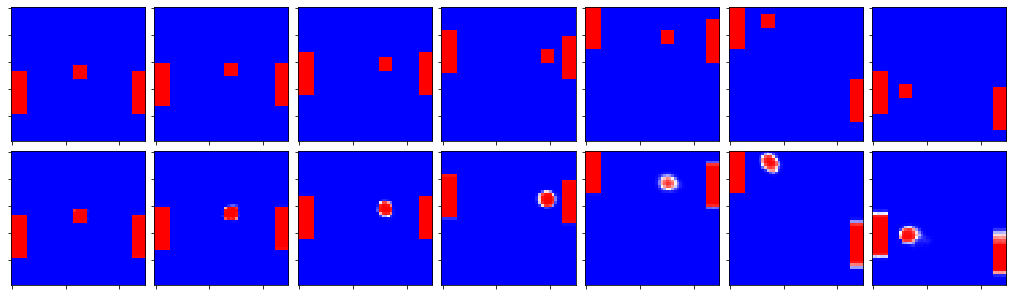

Epoch 50/150
100/100 [==============================] - 112s 1s/step - loss: 0.5825 - frames_loss: 0.0131 - lambda_13_loss: 0.5694 - frames_mean_squared_error: 0.0039 - frames_acc: 0.9947 - lambda_13_mean_squared_error: 346.0587 - lambda_13_acc: 0.9631 - val_loss: 0.3769 - val_frames_loss: 0.0117 - val_lambda_13_loss: 0.3653 - val_frames_mean_squared_error: 0.0035 - val_frames_acc: 0.9953 - val_lambda_13_mean_squared_error: 354.0118 - val_lambda_13_acc: 0.9763


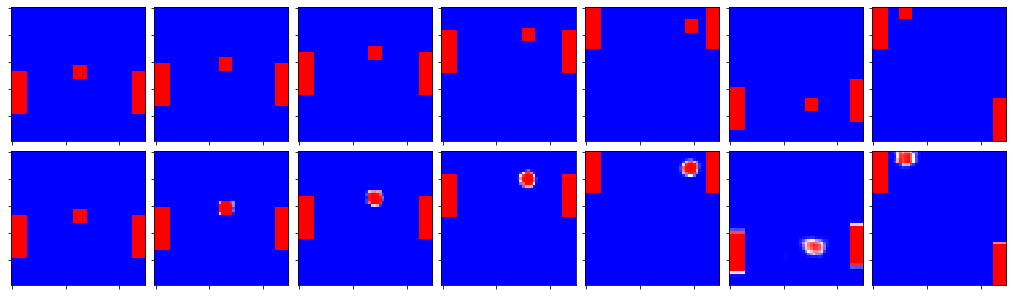

Epoch 51/150
100/100 [==============================] - 111s 1s/step - loss: 0.5497 - frames_loss: 0.0118 - lambda_13_loss: 0.5379 - frames_mean_squared_error: 0.0035 - frames_acc: 0.9952 - lambda_13_mean_squared_error: 381.8174 - lambda_13_acc: 0.9651 - val_loss: 0.8115 - val_frames_loss: 0.0131 - val_lambda_13_loss: 0.7984 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9945 - val_lambda_13_mean_squared_error: 373.9771 - val_lambda_13_acc: 0.9482


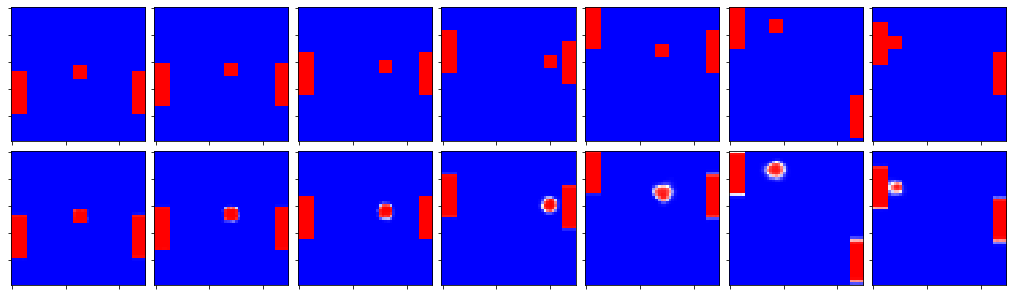

Epoch 52/150
100/100 [==============================] - 112s 1s/step - loss: 0.5770 - frames_loss: 0.0119 - lambda_13_loss: 0.5651 - frames_mean_squared_error: 0.0036 - frames_acc: 0.9951 - lambda_13_mean_squared_error: 376.2418 - lambda_13_acc: 0.9634 - val_loss: 0.8911 - val_frames_loss: 0.0118 - val_lambda_13_loss: 0.8793 - val_frames_mean_squared_error: 0.0035 - val_frames_acc: 0.9952 - val_lambda_13_mean_squared_error: 363.1609 - val_lambda_13_acc: 0.9430


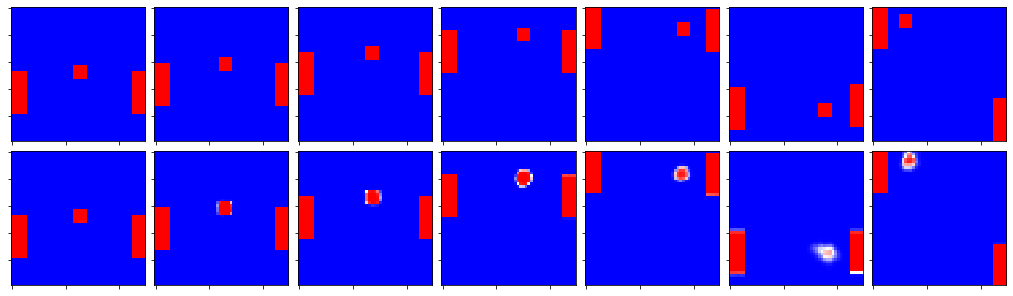

Epoch 53/150
100/100 [==============================] - 112s 1s/step - loss: 0.5818 - frames_loss: 0.0120 - lambda_13_loss: 0.5698 - frames_mean_squared_error: 0.0036 - frames_acc: 0.9951 - lambda_13_mean_squared_error: 368.6922 - lambda_13_acc: 0.9631 - val_loss: 0.4232 - val_frames_loss: 0.0109 - val_lambda_13_loss: 0.4124 - val_frames_mean_squared_error: 0.0033 - val_frames_acc: 0.9956 - val_lambda_13_mean_squared_error: 435.7993 - val_lambda_13_acc: 0.9733


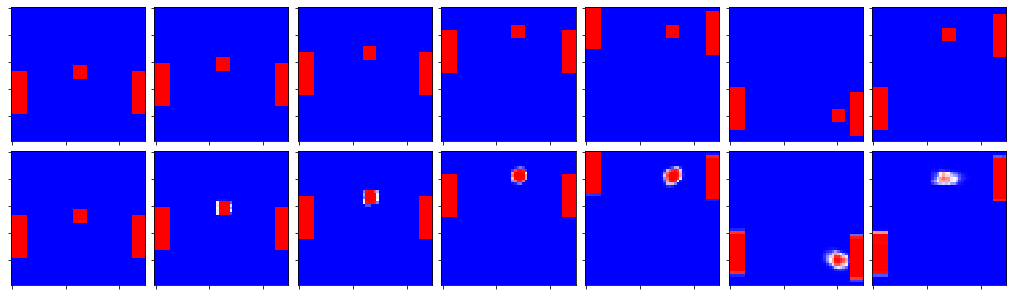

Epoch 54/150
 67/100 [===================>..........] - ETA: 36s - loss: 0.6291 - frames_loss: 0.0127 - lambda_13_loss: 0.6165 - frames_mean_squared_error: 0.0038 - frames_acc: 0.9948 - lambda_13_mean_squared_error: 359.2195 - lambda_13_acc: 0.9600

KeyboardInterrupt: 

In [90]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=150,
    callbacks=callbacks
)

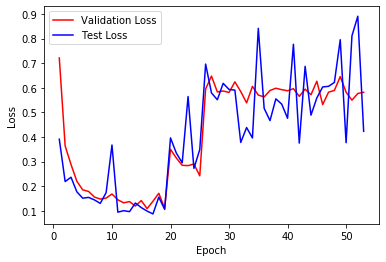

In [91]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

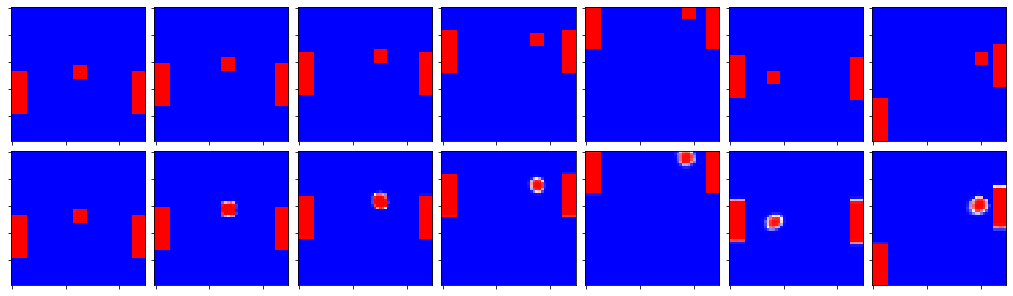

Epoch 1/150
100/100 [==============================] - 112s 1s/step - loss: 0.5993 - frames_loss: 0.0110 - lambda_13_loss: 0.5883 - frames_mean_squared_error: 0.0033 - frames_acc: 0.9955 - lambda_13_mean_squared_error: 381.5727 - lambda_13_acc: 0.9619 - val_loss: 0.4514 - val_frames_loss: 0.0108 - val_lambda_13_loss: 0.4406 - val_frames_mean_squared_error: 0.0032 - val_frames_acc: 0.9957 - val_lambda_13_mean_squared_error: 361.7016 - val_lambda_13_acc: 0.9714


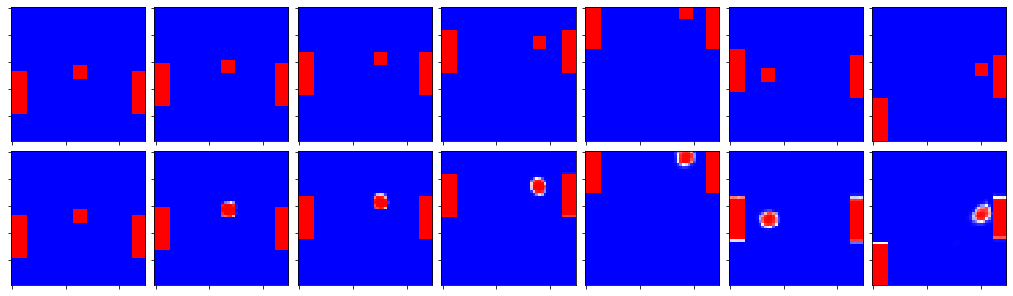

Epoch 2/150
100/100 [==============================] - 112s 1s/step - loss: 0.6251 - frames_loss: 0.0114 - lambda_13_loss: 0.6137 - frames_mean_squared_error: 0.0034 - frames_acc: 0.9953 - lambda_13_mean_squared_error: 379.5621 - lambda_13_acc: 0.9602 - val_loss: 0.5639 - val_frames_loss: 0.0122 - val_lambda_13_loss: 0.5517 - val_frames_mean_squared_error: 0.0037 - val_frames_acc: 0.9949 - val_lambda_13_mean_squared_error: 365.4861 - val_lambda_13_acc: 0.9642


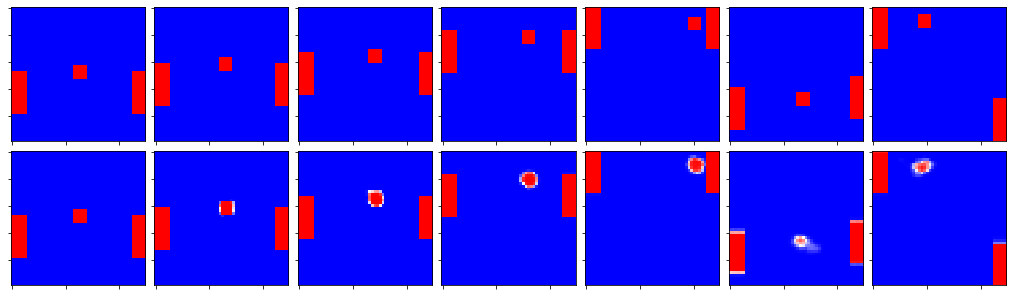

Epoch 3/150
100/100 [==============================] - 112s 1s/step - loss: 0.5664 - frames_loss: 0.0116 - lambda_13_loss: 0.5549 - frames_mean_squared_error: 0.0035 - frames_acc: 0.9953 - lambda_13_mean_squared_error: 368.8287 - lambda_13_acc: 0.9640 - val_loss: 0.3787 - val_frames_loss: 0.0134 - val_lambda_13_loss: 0.3653 - val_frames_mean_squared_error: 0.0040 - val_frames_acc: 0.9944 - val_lambda_13_mean_squared_error: 381.0079 - val_lambda_13_acc: 0.9763


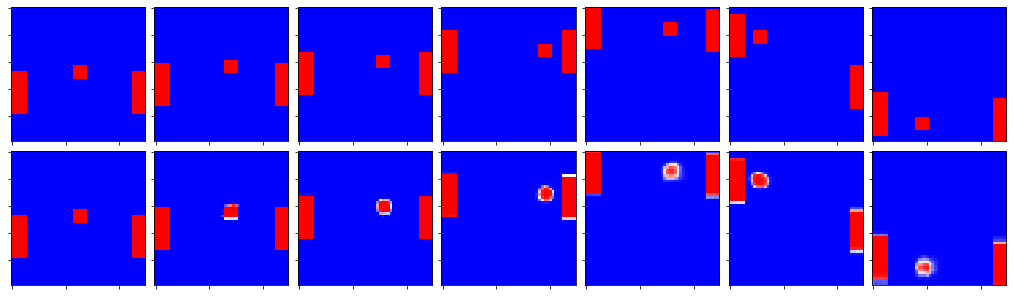

Epoch 4/150
100/100 [==============================] - 112s 1s/step - loss: 0.6171 - frames_loss: 0.0126 - lambda_13_loss: 0.6045 - frames_mean_squared_error: 0.0038 - frames_acc: 0.9948 - lambda_13_mean_squared_error: 337.9719 - lambda_13_acc: 0.9608 - val_loss: 0.3416 - val_frames_loss: 0.0102 - val_lambda_13_loss: 0.3314 - val_frames_mean_squared_error: 0.0030 - val_frames_acc: 0.9960 - val_lambda_13_mean_squared_error: 353.2501 - val_lambda_13_acc: 0.9785


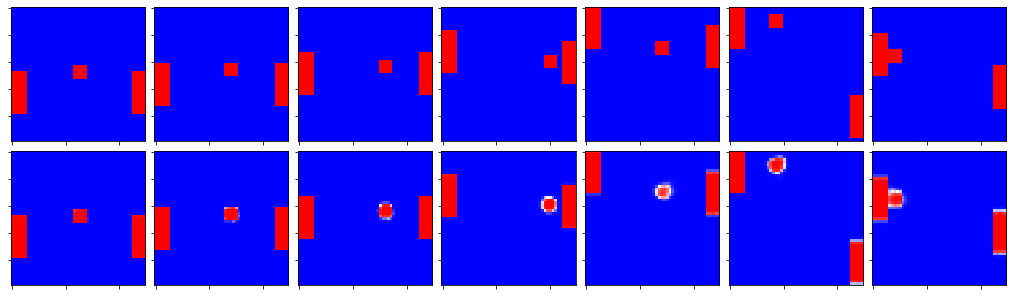

Epoch 5/150
 81/100 [=======================>......] - ETA: 21s - loss: 0.5928 - frames_loss: 0.0105 - lambda_13_loss: 0.5823 - frames_mean_squared_error: 0.0031 - frames_acc: 0.9958 - lambda_13_mean_squared_error: 378.0627 - lambda_13_acc: 0.9623

In [ ]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=150,
    callbacks=callbacks
)

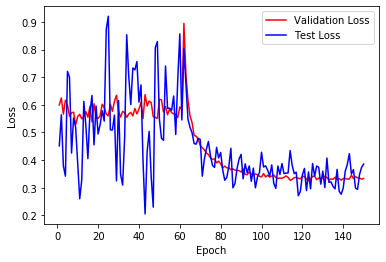

In [161]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

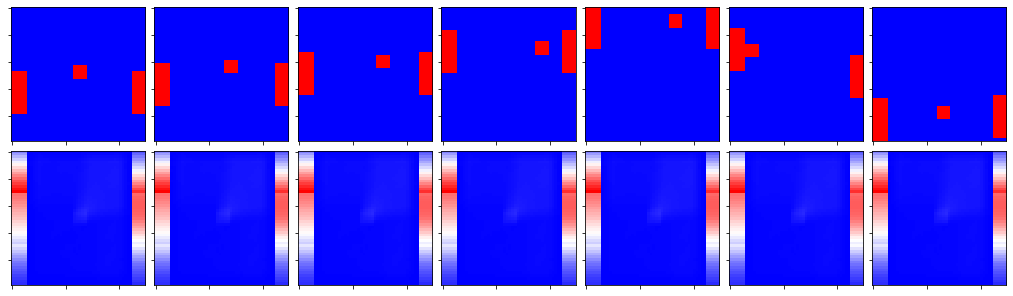

In [163]:
plot_pairwise_frames(frame_nums)

In [162]:
stateful = model.copy_in_stateful_model()
stateful.init(0.4)
t = 0

stateful.net.save('STATEFUL_LSTM3_PONG_RELU.hdf5')

In [ ]:
t += 1
frame, _ = stateful.single_step_predict([-1, 1])

plt.imshow(frame > 0.5)
t